In [2]:
import os

def count_images_in_folder(folder_path, valid_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
    # List all files in the folder and filter by valid image extensions
    image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(valid_extensions)]
    return len(image_files)

# Specify the folder path
folder_path = "DataCollected/IMG0"

# Count images
num_images = count_images_in_folder(folder_path)
print(f"Number of images in '{folder_path}': {num_images}")


Number of images in 'DataCollected/IMG0': 9417


Using device: cuda
Epoch 1/10, Train Loss: 0.5345, Test Loss: 0.4418, Train Accuracy: 75.47%, Test Accuracy: 80.04%
Epoch 2/10, Train Loss: 0.4526, Test Loss: 0.4090, Train Accuracy: 80.09%, Test Accuracy: 81.95%
Epoch 3/10, Train Loss: 0.4296, Test Loss: 0.4062, Train Accuracy: 80.98%, Test Accuracy: 81.58%
Epoch 4/10, Train Loss: 0.4247, Test Loss: 0.3893, Train Accuracy: 81.04%, Test Accuracy: 82.70%
Epoch 5/10, Train Loss: 0.4148, Test Loss: 0.4001, Train Accuracy: 81.84%, Test Accuracy: 82.38%
Epoch 6/10, Train Loss: 0.4149, Test Loss: 0.3861, Train Accuracy: 81.72%, Test Accuracy: 83.23%
Epoch 7/10, Train Loss: 0.4039, Test Loss: 0.3796, Train Accuracy: 82.25%, Test Accuracy: 81.85%
Epoch 8/10, Train Loss: 0.4039, Test Loss: 0.3813, Train Accuracy: 82.48%, Test Accuracy: 82.75%
Epoch 9/10, Train Loss: 0.3964, Test Loss: 0.3742, Train Accuracy: 82.77%, Test Accuracy: 83.23%
Epoch 10/10, Train Loss: 0.3934, Test Loss: 0.3596, Train Accuracy: 82.53%, Test Accuracy: 83.86%


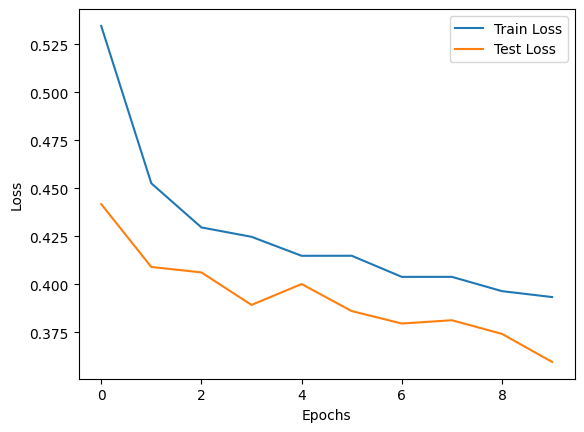

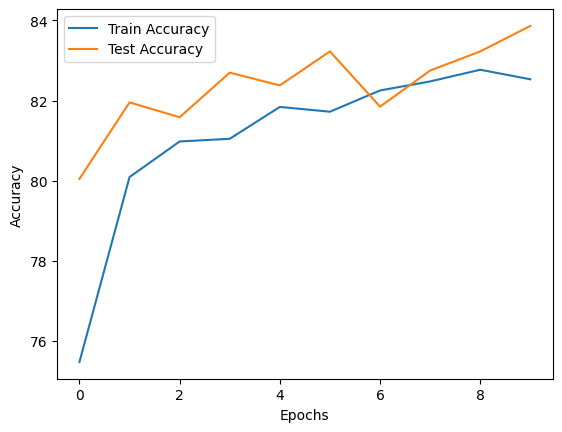

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

# Dataset class
# Dataset class remains the same
class SteeringControlDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        if not img_name.startswith(self.image_folder):
            img_name = os.path.join(self.image_folder, os.path.basename(img_name))
        image = Image.open(img_name)
        image = image.convert('RGB')  # Ensures images are in RGB format
        label = torch.tensor(int(self.data.iloc[idx, 1]))
        if self.transform:
            image = self.transform(image)
        return image, label

# Updated transformations with added augmentation
transform = transforms.Compose([
    transforms.Resize((240, 640)),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2),
    transforms.GaussianBlur(kernel_size=(5, 5)),
    transforms.ToTensor(),
])

# Dataset paths
csv_file = 'DataCollected/logfile.csv'
image_folder = 'DataCollected/IMG0'

# Initialize the dataset
dataset = SteeringControlDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

#split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# TinyVGG Model
class TinyVGGModel(nn.Module):
    def __init__(self):
        super(TinyVGGModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 30 * 80, 128)  # Adjust the dimensions according to the input size
        self.fc2 = nn.Linear(128, 3)  # For 3 classes (Forward, right,Left)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Setup for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TinyVGGModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Accuracy calculation
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training loop
num_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    train_losses.append(running_loss / len(train_loader))
    
    # Testing
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracy = calculate_accuracy(test_loader, model)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Accuracy: {test_accuracy:.2f}%")

# Plot training and testing progress
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [5]:
# Save the trained model
model_save_path = 'steering_control_model_tinyvgg.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to steering_control_model_tinyvgg.pth


In [4]:

import torch.nn as nn
# TinyVGG Model
class TinyVGGModel(nn.Module):
    def __init__(self):
        super(TinyVGGModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 30 * 80, 128)  # Adjust the dimensions according to the input size
        self.fc2 = nn.Linear(128, 3)  # For 3 classes (Forward, Left, Stop)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Setup for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load the trained model
model = TinyVGGModel().to(device)
model.load_state_dict(torch.load('steering_control_model_tinyvgg.pth', map_location=device))
model.eval()
print("Model loaded and ready for testing.")


Model loaded and ready for testing.


C:\Users\Nithin\AppData\Local\Temp\ipykernel_5996\333597697.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('steering_control_model_tiny

# test video

In [17]:
import cv2
from torchvision import transforms
from PIL import Image
import torch
import torch.nn.functional as F

# Load the trained model
model = TinyVGGModel().to(device)
model.load_state_dict(torch.load('steering_control_model_tinyvgg.pth', map_location=device))
model.eval()

# Define transformations for video frames
video_transform = transforms.Compose([
    transforms.Resize((240, 640)),
    transforms.ToTensor(),
])

# Labels mapping
label_map = {0: 'Forward', 1: 'Right', 2: 'left'}

# Open the video file DEEP LEARNING PYTORCH/captured_video1.avi
video_path = 'captured_video1.avi'  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Process video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to PIL Image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Apply transformations
    input_tensor = video_transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        label = label_map[predicted.item()]

    # Display the frame with prediction
    frame = cv2.putText(frame, f'Prediction: {label}', (20, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Video Prediction', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


C:\Users\Nithin\AppData\Local\Temp\ipykernel_5996\2731302522.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('steering_control_model_tin

# image test

In [16]:
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyVGGModel()  # Replace with your model class name
model.load_state_dict(torch.load("steering_control_model_tinyvgg.pth", map_location=device))
model.eval()  # Set the model to evaluation mode
model.to(device)

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((240, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Same normalization as training
])

# Class labels (change as per your dataset: 0 = Forward, 1 = Left, 2 = Stop)
class_labels = ["Forward", "Left", "Stop"]

def predict_image(image_path):
    """Predict the label for a single image."""
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Ensure RGB mode
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the input to the same device as the model
    input_tensor = input_tensor.to(device)
    
    # Make the prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_class = torch.max(outputs, 1)
    
    # Get the label
    predicted_label = class_labels[predicted_class.item()]
    
    # Display the image and prediction
    print(f"Predicted label: {predicted_label}")
    image.show()  # Open the image for visualization (optional)
    
    return predicted_label

# Test the function on an example image
image_path = "DataCollected/IMG0/Image_20241129_171142_401756.png"  # Replace with your test image path
predicted_label = predict_image(image_path)
print(f"Prediction: {predicted_label}")


C:\Users\Nithin\AppData\Local\Temp\ipykernel_5996\2612155629.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("steering_control_model_tin

Predicted label: Left
Prediction: Left


# confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

def plot_confusion_matrix(loader, model):
    # Set the model to evaluation mode
    model.eval()
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Convert confusion matrix to a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=[f'Class {i}' for i in range(3)], columns=[f'Class {i}' for i in range(3)])
    
    # Plot confusion matrix using Seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.show()


C:\Users\Nithin\AppData\Local\Temp\ipykernel_10060\3611660180.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('steering_control_model_ti

Model loaded and ready for testing.


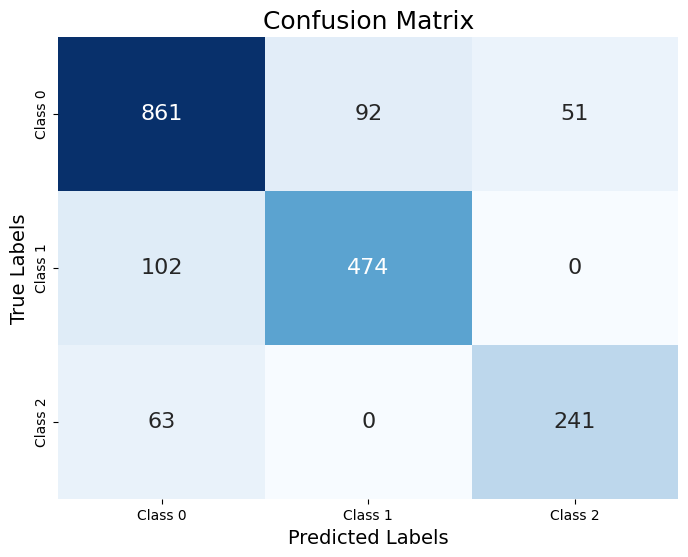

In [21]:
model = TinyVGGModel().to(device)
model.load_state_dict(torch.load('steering_control_model_tinyvgg.pth', map_location=device))
model.eval()
print("Model loaded and ready for testing.")
# Assuming 'test_loader' is the DataLoader for the test set
# and 'model' is your trained model

plot_confusion_matrix(test_loader, model)


# model2 Training with improved augmentation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from torch.optim.lr_scheduler import StepLR

# Dataset class
class SteeringControlDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        if not img_name.startswith(self.image_folder):
            img_name = os.path.join(self.image_folder, img_name)
        image = Image.open(img_name)
        label = torch.tensor(int(self.data.iloc[idx, 1]))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define data augmentation and transformations
transform = transforms.Compose([
    transforms.Resize((240, 640)),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.GaussianBlur(kernel_size=(5, 5)),
    transforms.ToTensor(),
])

csv_file = 'DataCollected/logfile.csv'  # Update with the correct CSV path
image_folder = 'DataCollected/IMG0'    # Update with the correct image folder path

# Initialize dataset and dataloaders
dataset = SteeringControlDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition
class ImprovedVGG(nn.Module):
    def __init__(self):
        super(ImprovedVGG, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 30 * 80, 256)
        self.fc2 = nn.Linear(256, 3)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler

# Early stopping parameters
best_accuracy = 0.0
patience = 4
no_improvement_epochs = 0

# Training function
def train_model(num_epochs=10):
    global best_accuracy, no_improvement_epochs
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct / total
        epoch_loss = running_loss / len(train_loader)
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = 100 * correct / total
        epoch_test_loss = test_loss / len(test_loader)
        
        # Early stopping check
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
        
        # Early stopping check
        if no_improvement_epochs >= patience:
            print("Early stopping")
            break
        
        # Step learning rate scheduler
        scheduler.step()

# Start training
train_model(num_epochs=10)




Epoch 1/10, Train Loss: 0.6893, Test Loss: 0.5759, Train Accuracy: 65.29%, Test Accuracy: 70.81%
Epoch 2/10, Train Loss: 0.6064, Test Loss: 0.6408, Train Accuracy: 68.83%, Test Accuracy: 62.15%
Epoch 3/10, Train Loss: 0.6070, Test Loss: 0.5342, Train Accuracy: 68.10%, Test Accuracy: 75.00%
Epoch 4/10, Train Loss: 0.5944, Test Loss: 0.6000, Train Accuracy: 69.72%, Test Accuracy: 67.83%
Epoch 5/10, Train Loss: 0.5878, Test Loss: 0.5819, Train Accuracy: 69.39%, Test Accuracy: 67.57%
Epoch 6/10, Train Loss: 0.5372, Test Loss: 0.5174, Train Accuracy: 74.25%, Test Accuracy: 74.47%
Epoch 7/10, Train Loss: 0.5092, Test Loss: 0.4975, Train Accuracy: 75.55%, Test Accuracy: 76.27%
Epoch 8/10, Train Loss: 0.5062, Test Loss: 0.4920, Train Accuracy: 75.99%, Test Accuracy: 75.85%
Epoch 9/10, Train Loss: 0.4990, Test Loss: 0.4913, Train Accuracy: 76.21%, Test Accuracy: 77.02%
Epoch 10/10, Train Loss: 0.5002, Test Loss: 0.4873, Train Accuracy: 76.14%, Test Accuracy: 76.59%


In [7]:
num_epochs=10

In [10]:
# Saving the model

torch.save(model.state_dict(), 'steering_control_model_tinyvgg1.pth')


In [13]:
# Model definition
class ImprovedVGG(nn.Module):
    def __init__(self):
        super(ImprovedVGG, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 30 * 80, 256)
        self.fc2 = nn.Linear(256, 3)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedVGG().to(device)

In [15]:
# Load the trained model
model = ImprovedVGG().to(device)
model.load_state_dict(torch.load('steering_control_model_tinyvgg1.pth', map_location=device))
model.eval()
print("Model loaded and ready for testing.")


Model loaded and ready for testing.


C:\Users\Nithin\AppData\Local\Temp\ipykernel_20220\2470576037.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('steering_control_model_ti

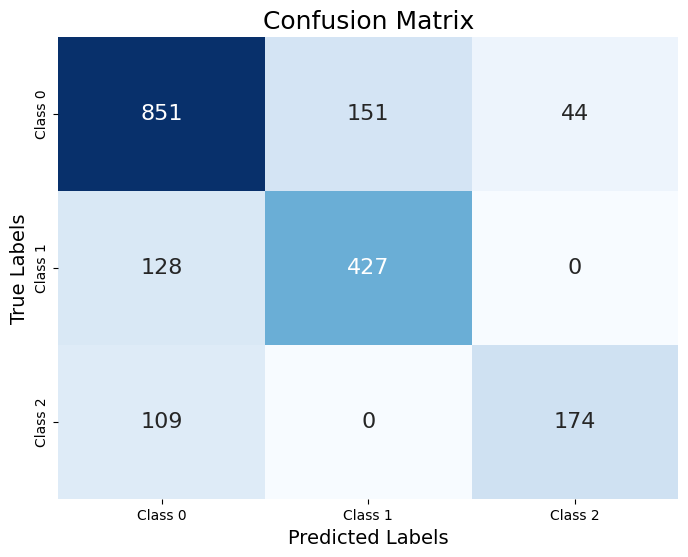

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

def plot_confusion_matrix(loader, model):
    # Set the model to evaluation mode
    model.eval()
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Convert confusion matrix to a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=[f'Class {i}' for i in range(3)], columns=[f'Class {i}' for i in range(3)])
    
    # Plot confusion matrix using Seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.show()
plot_confusion_matrix(test_loader, model)


In [18]:
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedVGG()  # Replace with your model class name
model.load_state_dict(torch.load("steering_control_model_tinyvgg1.pth", map_location=device))
model.eval()  # Set the model to evaluation mode
model.to(device)

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((240, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Same normalization as training
])

# Class labels (change as per your dataset: 0 = Forward, 1 = Left, 2 = Stop)
class_labels = ["Forward", "Left", "Stop"]

def predict_image(image_path):
    """Predict the label for a single image."""
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Ensure RGB mode
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the input to the same device as the model
    input_tensor = input_tensor.to(device)
    
    # Make the prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_class = torch.max(outputs, 1)
    
    # Get the label
    predicted_label = class_labels[predicted_class.item()]
    
    # Display the image and prediction
    print(f"Predicted label: {predicted_label}")
    image.show()  # Open the image for visualization (optional)
    
    return predicted_label

# Test the function on an example image
image_path = "DataCollected/IMG0/Image_20241129_171142_401756.png"  # Replace with your test image path
predicted_label = predict_image(image_path)
print(f"Prediction: {predicted_label}")


C:\Users\Nithin\AppData\Local\Temp\ipykernel_20220\95553366.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("steering_control_model_tiny

Predicted label: Forward
Prediction: Forward


In [19]:
# video test

In [21]:
import cv2
from torchvision import transforms
from PIL import Image
import torch
import torch.nn.functional as F

# Load the trained model
model = ImprovedVGG().to(device)
model.load_state_dict(torch.load('steering_control_model_tinyvgg1.pth', map_location=device))
model.eval()

# Define transformations for video frames
video_transform = transforms.Compose([
    transforms.Resize((240, 640)),
    transforms.ToTensor(),
])

# Labels mapping
label_map = {0: 'Forward', 1: 'Right', 2: 'left'}

# Open the video file DEEP LEARNING PYTORCH/captured_video1.avi
video_path = 'captured_video1.avi'  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Process video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to PIL Image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Apply transformations
    input_tensor = video_transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        label = label_map[predicted.item()]

    # Display the frame with prediction
    frame = cv2.putText(frame, f'Prediction: {label}', (20, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Video Prediction', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


C:\Users\Nithin\AppData\Local\Temp\ipykernel_20220\275031679.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('steering_control_model_tin

# 2]pretttrained MobileNetV2 model 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import pandas as pd
import os

# Dataset class
class SteeringControlDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        if not img_name.startswith(self.image_folder):
            img_name = os.path.join(self.image_folder, img_name)
        image = Image.open(img_name).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# Paths
csv_file = "DataCollected/logfile.csv"
image_folder = "DataCollected/IMG0"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2),
    transforms.GaussianBlur(kernel_size=(5, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pretrained models
])

# Dataset and DataLoader
dataset = SteeringControlDataset(csv_file, image_folder, transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model: MobileNetV2
model = models.mobilenet_v2(pretrained=True)
# Modify the last layer for 3 classes (Forward, Left, Stop)
model.classifier[1] = nn.Linear(model.last_channel, 3)  # 3 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation
def calculate_accuracy(loader, model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

num_epochs = 5
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluation phase
    train_accuracy = calculate_accuracy(train_loader, model)
    test_accuracy = calculate_accuracy(test_loader, model)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")




In [ ]:
# Save the model
torch.save(model.state_dict(), "mobilenetv2_model0.pth")
print("Model saved to mobilenetv2_model0.pth")


In [ ]:

# Load and test the model
def test_model_on_images(model_path, test_loader):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded successfully.")

    test_accuracy = calculate_accuracy(test_loader, model)
    print(f"Test Accuracy: {test_accuracy:.2f}%")

test_model_on_images("mobilenetv2_model0.pth", test_loader)